# Overview

In [226]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [227]:
df = pd.read_csv("..\data\cleaned.csv")
#drop row if pager_code == training
df = df[df.pager_code != 'Training']

# Date analysis

In [133]:
# number of callouts in a given year/quarter.
# # what is the range in dates
# print(df['date_of_shout'].min()) #01/05/2022
# print(df['date_of_shout'].max()) #31/12/2021

In [134]:
# Convert to datetime
df['date_of_shout'] = pd.to_datetime(df['date_of_shout'])
df['quarter'] = df['date_of_shout'].dt.quarter
df['year'] = df['date_of_shout'].dt.year

# Define a mapping for quarters
quarter_labels = {
    1: 'Jan-Mar',
    2: 'Apr-Jun',
    3: 'Jul-Sep',
    4: 'Oct-Dec'
}

df[['date_of_shout','quarter','year']].head()

C:\Users\RhysL\AppData\Local\Temp\ipykernel_19824\3369430959.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_of_shout'] = pd.to_datetime(df['date_of_shout'])


,date_of_shout,quarter,year
0,2023-07-21,3,2023
1,2023-07-19,3,2023
2,2023-07-16,3,2023
3,2023-07-08,3,2023
4,2023-07-05,3,2023


In [135]:
# Define function to count codes separately
def count_codes_222(series):
    return (series == 222).sum()

def count_codes_333(series):
    return (series == 333).sum()

def count_codes_999(series):
    return (series == 999).sum()

# Group by year and quarter and count codes separately
df_grouped = df.groupby(['year', 'quarter'])
counts_222 = df_grouped['pager_code'].apply(count_codes_222).reset_index(name='count_222')
counts_333 = df_grouped['pager_code'].apply(count_codes_333).reset_index(name='count_333')
counts_999 = df_grouped['pager_code'].apply(count_codes_999).reset_index(name='count_999')

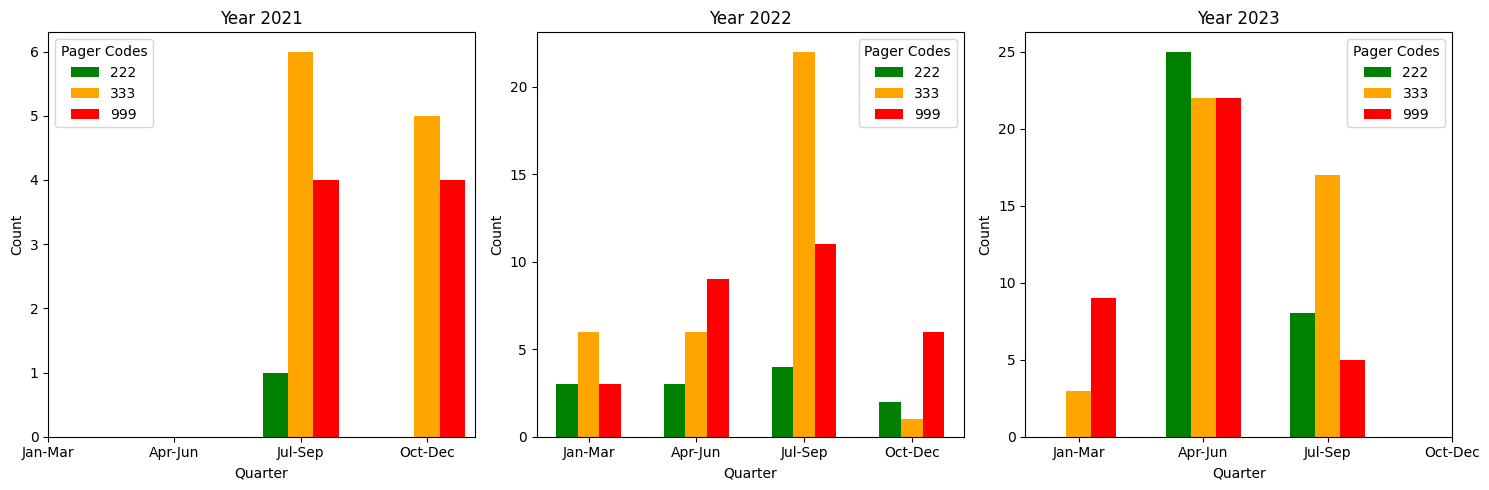

In [136]:

color_mapping = {222: 'green', 333: 'orange', 999: 'red'}


# Plotting all graphs together
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for idx, year in enumerate(counts_222['year'].unique()):
    df_year_222 = counts_222[counts_222['year'] == year]
    df_year_333 = counts_333[counts_333['year'] == year]
    df_year_999 = counts_999[counts_999['year'] == year]
    
    ax = axes[idx]
    ax.bar(df_year_222['quarter'] - 0.2, df_year_222['count_222'], width=0.2,color=color_mapping[222], label='222')
    ax.bar(df_year_333['quarter'], df_year_333['count_333'], width=0.2,color=color_mapping[333], label='333')
    ax.bar(df_year_999['quarter'] + 0.2, df_year_999['count_999'], width=0.2, color=color_mapping[999],label='999')
    
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Quarter')
    ax.set_ylabel('Count')
    ax.legend(title='Pager Codes')
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels([quarter_labels[q] for q in range(1, 5)])

plt.tight_layout()
plt.show()



# Time analysis


For each person what are their callout time distributions? (or those with a significant number of incidents atteneded).

In [6]:
feats=['time_of_shout','time_boat_launched','time_boat_returned']
# dft=df[feats]
# As a placeholder for missing values we entered "00:00" in for time features
#We replace them with NaN

# Replace "00:00" with NaN
df['time_of_shout'] = df['time_of_shout'].replace("00:00", np.nan)
df['time_boat_launched'] = df['time_boat_launched'].replace("00:00", np.nan)
df['time_boat_returned'] = df['time_boat_returned'].replace("00:00", np.nan)

# Display the DataFrame
# print(df[feats].head(88))

# Convert time columns to datetime format
df['time_of_shout'] = pd.to_datetime(df['time_of_shout'], format='%H:%M')
df['time_boat_launched'] = pd.to_datetime(df['time_boat_launched'], format='%H:%M')
df['time_boat_returned'] = pd.to_datetime(df['time_boat_returned'], format='%H:%M')

# Define a function to calculate time difference considering crossing midnight
def time_difference(start, end):
    if start <= end:
        return (end - start).total_seconds() / 60
    else:
        midnight = pd.Timestamp(end.date()) + pd.Timedelta(days=1)
        return (midnight - start).total_seconds() / 60 + (end - pd.Timestamp(end.date())).total_seconds() / 60

# Determine time between "time_of_shout" and "time_boat_launched" if values are not NaN
df['shout_launch_time'] = df.apply(
    lambda row: time_difference(row['time_of_shout'], row['time_boat_launched'])
    if pd.notnull(row['time_of_shout']) and pd.notnull(row['time_boat_launched']) else np.nan, axis=1)

# Determine time between "time_boat_launched" and "time_boat_returned" if values are not NaN
df['launch_return_time'] = df.apply(
    lambda row: time_difference(row['time_boat_launched'], row['time_boat_returned'])
    if pd.notnull(row['time_boat_launched']) and pd.notnull(row['time_boat_returned']) else np.nan, axis=1)


# Determine the shout_to_return_time if values are not NaN
df['shout_to_return_time'] = df.apply(
    lambda row: time_difference(row['time_of_shout'], row['time_boat_returned'])
    if pd.notnull(row['time_of_shout']) and pd.notnull(row['time_boat_returned']) else np.nan, axis=1)

In [7]:
feats_more=feats+["shout_launch_time",'launch_return_time','shout_to_return_time']
df['time_of_shout'] = df['time_of_shout'].dt.time
df['time_boat_launched'] = df['time_boat_launched'].dt.time
df['time_boat_returned'] = df['time_boat_returned'].dt.time
# print(df[feats_more].head(88))

In [8]:
# check if any shout_launch_time  or launch_return_time   are negative
# print(df[df['shout_launch_time'] < 0]) #none
# print(df[df['launch_return_time'] < 0])# none

#count the number of rows which have no nan in either shout_launch_time or launch_return_time
# df.shape[0]#207
# print(df.dropna(subset=[ 'launch_return_time']).shape[0]) #183
# print(df.dropna(subset=['shout_launch_time']).shape[0]) #201

#drop rows with nan in either shout_launch_time or launch_return_time
dft=df.copy()
dft = dft.dropna(subset=['shout_launch_time', 'launch_return_time','shout_to_return_time'])
# print(dft.shape[0]) #183

183


In [9]:
feats=['pager_code','time_of_shout','time_boat_launched','time_boat_returned',"shout_launch_time","launch_return_time","shout_to_return_time"]
dft[feats].head()

,pager_code,time_of_shout,time_boat_launched,time_boat_returned,shout_launch_time,launch_return_time,shout_to_return_time
0,999,15:05:00,15:20:00,16:15:00,15.0,55.0,70.0
1,333,18:44:00,19:00:00,20:15:00,16.0,75.0,91.0
2,999,11:10:00,11:10:00,12:15:00,0.0,65.0,65.0
3,333,09:44:00,09:55:00,10:30:00,11.0,35.0,46.0
4,222,18:49:00,19:04:00,20:04:00,15.0,60.0,75.0


Given the time differences (shout_launch_time,launch_return_time,shout_to_return_time) we provide a boxplot for the pager_code 222,333,999. First we note we have outliers in these measurements.

In [10]:
dftpager_outliers = dft[(dft['shout_launch_time'] > 60) | 
                        (dft['launch_return_time'] > 400) | 
                        (dft['shout_to_return_time'] > 300)]
# dftpager_outliers.shape[0] #8

In [11]:
x=dftpager_outliers[['time_of_shout','time_boat_launched','time_boat_returned']+feats+["shout_details"]]
print(x.to_string(index=False))  # print full line


time_of_shout time_boat_launched time_boat_returned  pager_code time_of_shout time_boat_launched time_boat_returned  shout_launch_time  launch_return_time  shout_to_return_time                                                                                                                                                                                                                                                   shout_details
     19:15:00           19:08:00           21:15:00         222      19:15:00           19:08:00           21:15:00             1433.0               127.0                 120.0                                             Crew were out on training when flagged down by a member of the public to a bROken down ski south of duck bay marina with 1 person on board. Crew then secured the Jetski and towed it back to Duncan mills slipway.
     12:02:00           10:30:00           13:35:00         999      12:02:00           10:30:00           13:35:00             1348.0

We have outliers because the crew recorded a train exercise and an incident at the same time. It would have been better to note when the training finished or the incident started and log these as two separate events. Additionally the time of launch is before the time of shout - similary for the other outliers. We are working under the assumption that the time of shout precedes the time of boat launch. We now look at the boxplots for the time differences for the pager codes 222,333,999.



In [12]:
# Filter out outliers
dftpager = dft[(dft['shout_launch_time'] <= 60) & 
               (dft['launch_return_time'] <= 400) & 
               (dft['shout_to_return_time'] <= 300)]

# Melt the DataFrame to long format for boxplot
dftpager = dftpager.melt(id_vars='pager_code', var_name='feature', value_name='time')

# Select the features to plot
feats = ['pager_code', 'shout_launch_time', 'launch_return_time', 'shout_to_return_time']

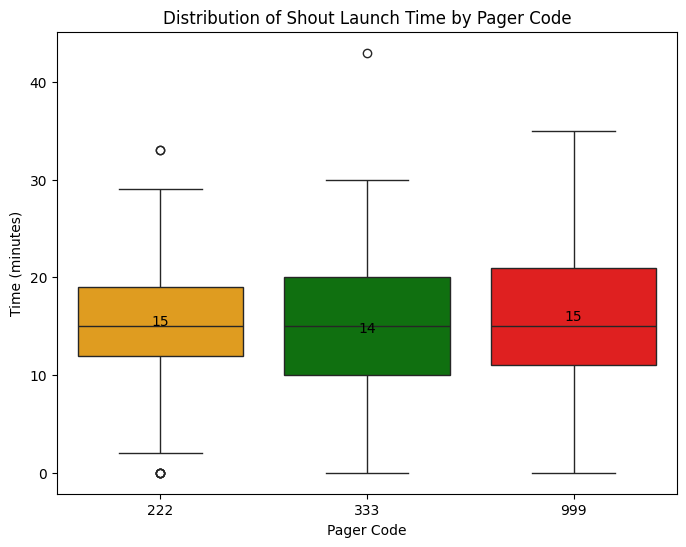

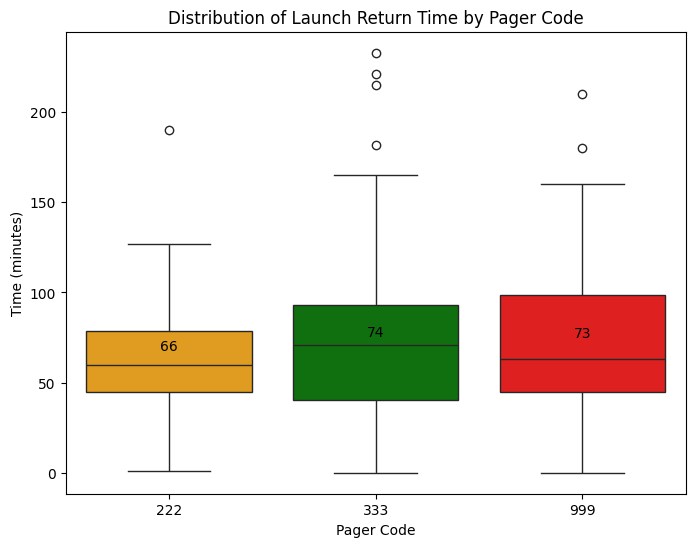

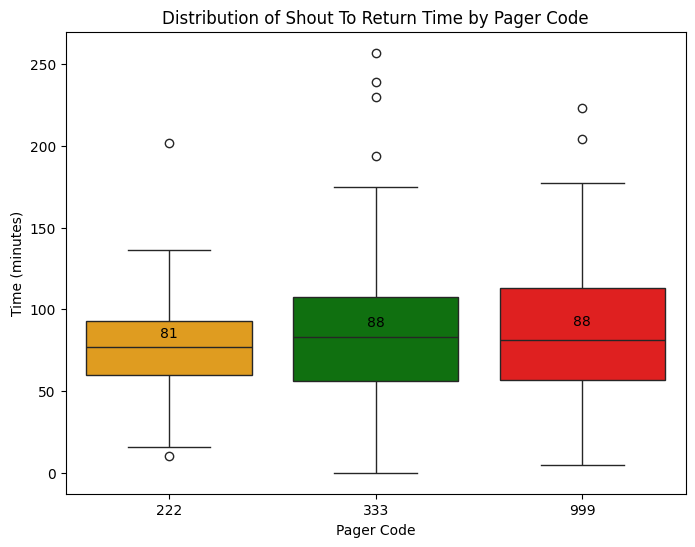

In [13]:
# Iterate over each feature and create a separate boxplot
for feat in feats[1:]:
    plt.figure(figsize=(8, 6))
    
    # Filter the DataFrame for the current feature
    filtered_data = dftpager[dftpager['feature'] == feat]
    
    # Extract unique pager codes and assign colors based on the mapping
    unique_pager_code = filtered_data['pager_code'].unique()
    colors = [color_mapping.get(code, 'blue') for code in unique_pager_code]
    
    # Boxplot with custom colors
    sns.boxplot(x='pager_code', y='time', hue='pager_code', data=filtered_data, palette=color_mapping, dodge=False)

    # Hide the legend
    plt.legend([],[], frameon=False)    
    
    # Extract the mean for each pager_code
    mean_values = filtered_data.groupby('pager_code')['time'].mean()
    
    # Annotate boxplot with mean values
    for i, mean in enumerate(mean_values):
        plt.text(i, mean, f'{round(mean)}', ha='center', va='bottom', color='black', fontsize=10)
    
    plt.xlabel('Pager Code')
    plt.ylabel('Time (minutes)')
    plt.title(f'Distribution of {feat.replace("_", " ").title()} by Pager Code')
    plt.show()


## Scatterplots times and length with pager code coloring 

In [ ]:


Pager for coloring. Get scatter plot for time occurs (x) and length of time y 

get three scatters for (shout to launch)./ shout to return/ launch to return    

do in time section.

# Crew analysis

Between 01/05/2022 and 31/12/2021 how many incidents have each crew memember attended and how are these incidents decomposed by pager code? We will view this as a stacked bar grap.



In [216]:
# df.columns.tolist()
# # df.shape[0]#207
# df.shape #207

In [228]:
# dft.shape[0]

crew={
    "RB": "Ronnie Britton",
    "RO": "Rennie Oliver",
    "IG": "Iain Gollan (Goz)",
    "AM": "Ally McLeod",
    "ABS": "Andy Biddulph Snr",
    "ABJ": "Andy Biddulph Jnr",
    "GD": "Gemma Dorran",
    "PBT": "Phils Brooks-Taylor",
    "DON": "David O'Neil",
    "CC": "Craig Clancy",
    "GH": "Gerry Heaney",
    "AJM": "Angus John MacDonald",
    "CMS": "Callum MacKenzie Stevens",
    "DS": "David Stuart",
    "TR": "Thomas Rogers",
    "EM": "Euan MciIwraith",
    "PD": "Paul Dorrian",
    "KM": "Kevin McPartland",
    "JB": "Jenna Biddulph",
    "VM": "Vicki Murphy",
    "JM": "John Mason",
    "AC": "Andy Connell",
    "FN": "Franny Nicol",
    "FR": "Frank Rogers",
    "CA": "Christine Allan",
    "CS": "Clinton Salter",
    "JT": "James Thomson",
    "TAM":"Tam (Cox)",
    "GERARD":"Gerard",
    "DAVY":"Davy",
    "LEE":"Lee",
}

crew_keys=list(crew.keys())

# I want to inspect
# df['crew_on_board']

#I want to turn each entry in this col into a tuple
df['crew_on_board'] = df['crew_on_board'].str.split(',').apply(lambda x: tuple(x) if isinstance(x, list) else tuple())
# df['crew_on_board']
df['crew_on_shore'] = df['crew_on_shore'].str.split(',').apply(lambda x: tuple(x) if isinstance(x, list) else tuple())


In [265]:
df['crew_on_shore'] 

0      (GH,  DON)
1      (RO,  ABS)
2              ()
3       (TR,  DO)
4       (RB,  AM)
          ...    
202            ()
203        (PBT,)
204    (PBT,  LS)
205      (RB, TR)
206         (TR,)
Name: crew_on_shore, Length: 207, dtype: object

In [249]:
def get_dictionaries(place,splitter=5):

    #count the number of incidents a given initial has atteneded (sum all the incidents they have atteneded)
    dict_board_crew = {}
    for crew_person in crew_keys:
        counter=0
        dict_board_crew[crew_person] = df[df[place].apply(lambda x: crew_person in x)].shape[0]
    # dict_board_crew

    #and record the initials of those with 0 incidents
    crew_no_incidents = [key for key in dict_board_crew.keys() if dict_board_crew[key] == 0]
    # crew_no_incidents #['GD', 'CC','JB','VM','JM','AC','FN','CA', 'TAM', 'GERARD','DAVY','LEE']
    print(crew_no_incidents)

    # remove those with 0 incidents from dict_crew
    dict_board_crew = {key: value for key, value in dict_board_crew.items() if value != 0}
    # crew_no_incidents

    # The total crew can be partitioned into those with more that (splitter) incidents and those with less than 6 incidents
    #get the crew that have been on less than (incidents and create dict_crew_reg and dict_crew_occasional
    dict_crew_reg = {}
    dict_crew_occasional = {}
    for key, value in dict_board_crew.items():
        if value <= splitter:
            dict_crew_occasional[key] = value
        else:
            dict_crew_reg[key] = value

    return dict_crew_reg,dict_crew_occasional

In [274]:
dict_crew_board_reg,dict_crew_board_occasional=get_dictionaries(place='crew_on_board',splitter=6)

#set splitter to...
dict_crew_shore_reg,dict_crew_shore_occasional=get_dictionaries(place='crew_on_shore',splitter=0)

['GD', 'CC', 'JB', 'VM', 'JM', 'AC', 'FN', 'CA', 'TAM', 'GERARD', 'DAVY', 'LEE']
['IG', 'AJM', 'CMS', 'EM', 'KM', 'VM', 'JM', 'AC', 'FN', 'FR', 'CA', 'CS', 'JT', 'TAM', 'GERARD', 'DAVY', 'LEE']


For each of these groups we decompose the total number of incidents by pager codes.

In [275]:
def counter(given_initials, data,place):    
    dict_counts = {999:0, 333:0, 222:0}
    for entry in data.to_dict(orient='records'):
        tup = entry[place]
        if given_initials in tup:
            dict_counts[entry['pager_code']] = dict_counts.get(entry['pager_code'], 0) + 1
    return dict_counts

def get_pager_counts(dict_crew_reg,dict_crew_occasional,place):

    dict_crew_reg_pager = {}
    for crew_person in dict_crew_reg:
        feats=['pager_code',place]
        dict_crew_reg_pager[crew_person] = counter(crew_person, df[feats],place)
    # dict_crew_reg_pager

    dict_crew_occasional_pager = {}
    for crew_person in dict_crew_occasional:
        dict_crew_occasional_pager[crew_person] = counter(crew_person, df[feats],place)
    # dict_crew_board_occasional_pager

    return dict_crew_reg_pager,dict_crew_occasional_pager



In [276]:
dict_crew_board_reg_pager,dict_crew_board_occasional_pager=get_pager_counts(dict_crew_board_reg,dict_crew_board_occasional,place='crew_on_board')

dict_crew_shore_reg_pager,dict_crew_shore_occasional_pager=get_pager_counts(dict_crew_shore_reg,dict_crew_shore_occasional,place='crew_on_shore')

In [277]:
dict_crew_shore_reg_pager

{'RB': {999: 7, 333: 10, 222: 4},
 'RO': {999: 1, 333: 2, 222: 1},
 'AM': {999: 0, 333: 2, 222: 0},
 'ABS': {999: 2, 333: 1, 222: 2},
 'ABJ': {999: 1, 333: 1, 222: 0},
 'GD': {999: 0, 333: 0, 222: 1},
 'PBT': {999: 0, 333: 1, 222: 1},
 'DON': {999: 2, 333: 3, 222: 2},
 'CC': {999: 0, 333: 1, 222: 0},
 'GH': {999: 3, 333: 1, 222: 2},
 'DS': {999: 1, 333: 1, 222: 0},
 'TR': {999: 3, 333: 6, 222: 1},
 'PD': {999: 1, 333: 1, 222: 0},
 'JB': {999: 0, 333: 0, 222: 1}}

In [278]:
# dict_crew_board_occasional_pager.keys()
#dict_keys(['IG', 'PBT', 'AJM', 'CMS', 'EM', 'PD', 'KM', 'FR', 'CS'])

In [279]:

def stacked_bar(dict_crew_pager, color_mapping, coxswains, safety_advisors,title):

    counts = dict_crew_pager
    initials = list(dict_crew_pager.keys()) 

    # Calculate the total count for each initial
    total_counts = {initial: sum(counts[initial].values()) for initial in initials}

    # Sort initials based on total count in descending order
    sorted_initials = sorted(initials, key=lambda x: total_counts[x], reverse=True)

    # Plotting the stacked bar graph
    fig, ax = plt.subplots()

    # Position for each bar
    positions = list(range(len(sorted_initials)))

    # Plotting each pager code for each initials as a stacked bar
    bottom = None
    for i, code in enumerate([999, 333, 222]):
        values = [counts[initial][code] for initial in sorted_initials]
        if bottom is None:
            ax.bar(positions, values, label=f'{code}', color=[color_mapping[code] for _ in sorted_initials])
            bottom = values
        else:
            ax.bar(positions, values, label=f'{code}', bottom=bottom, color=[color_mapping[code] for _ in sorted_initials])
            bottom = [bottom[j] + values[j] for j in range(len(bottom))]

    
    # Set y-scale to 45
    plt.ylim(0, 45)
    # Adding labels and title
    ax.set_xlabel('Crew Initials')
    ax.set_ylabel('# Incidents')
    ax.set_title(title)

    ax.set_xticks(positions)

    # Modify x-axis tick labels to highlight coxswains and place "*+" under both coxswains and safety advisors
    tick_labels = []
    for initial in sorted_initials:
        label = ""
        if initial in coxswains and initial in safety_advisors:
            label += "*+"
        elif initial in coxswains:
            label += "*"
        elif initial in safety_advisors:
            label += "+"
        tick_labels.append(initial + label)
        
    ax.set_xticklabels(tick_labels, fontsize='small')  # Increase the font size here

    # Creating a custom legend
    legend_labels = ['222', '333', '999', 'Coxswains', 'Safety Advisors']
    legend_handles = []
    for code in [222, 333, 999]:
        legend_handles.append(ax.bar(0, 0, color=color_mapping[code])[0])

    ax.legend(legend_handles, legend_labels, loc='upper right')

    # Displaying the plot
    plt.show()



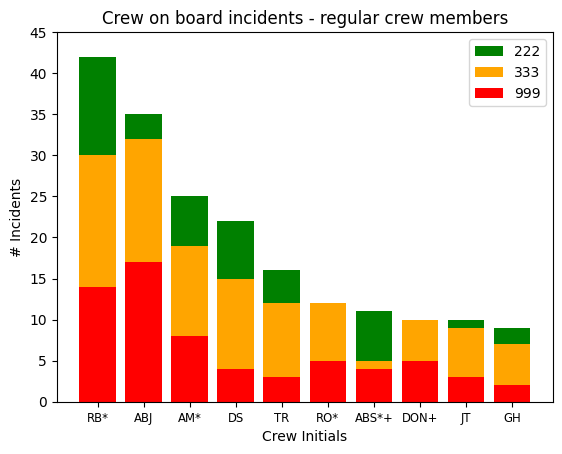

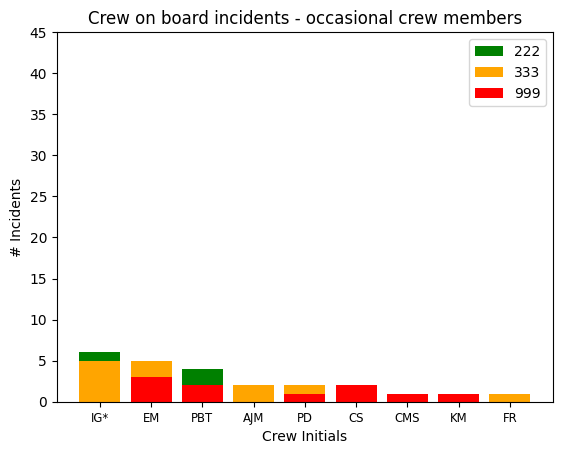

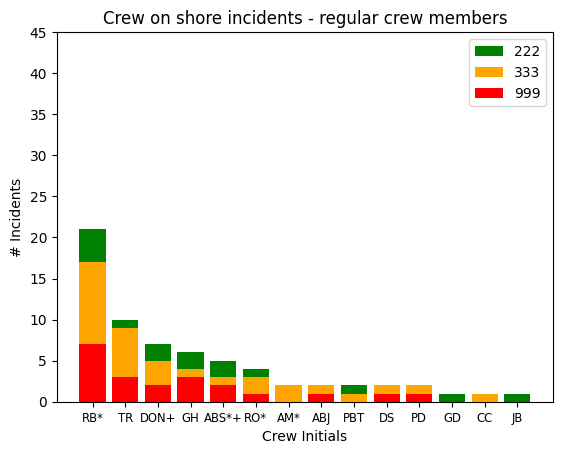

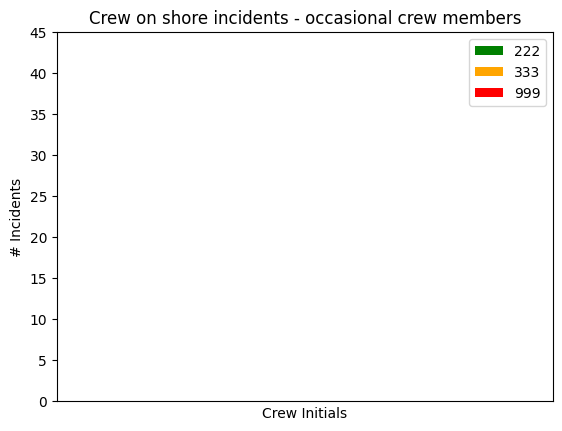

In [280]:
# #We note the coxswains with * and Safety Advisors with +
coxswains=["RB","RO","IG","AM","ABS"]
safety_advisors=["ABS","DON"]

stacked_bar(dict_crew_board_reg_pager,color_mapping,coxswains,safety_advisors,title="Crew on board incidents - regular crew members")

stacked_bar(dict_crew_board_occasional_pager,color_mapping,coxswains,safety_advisors,title="Crew on board incidents - occasional crew members")

stacked_bar(dict_crew_shore_reg_pager,color_mapping,coxswains,safety_advisors,title="Crew on shore incidents - regular crew members")

stacked_bar(dict_crew_shore_occasional_pager,color_mapping,coxswains,safety_advisors,title="Crew on shore incidents - occasional crew members")

## Boxplots person time of shout (what time do they usually attend).

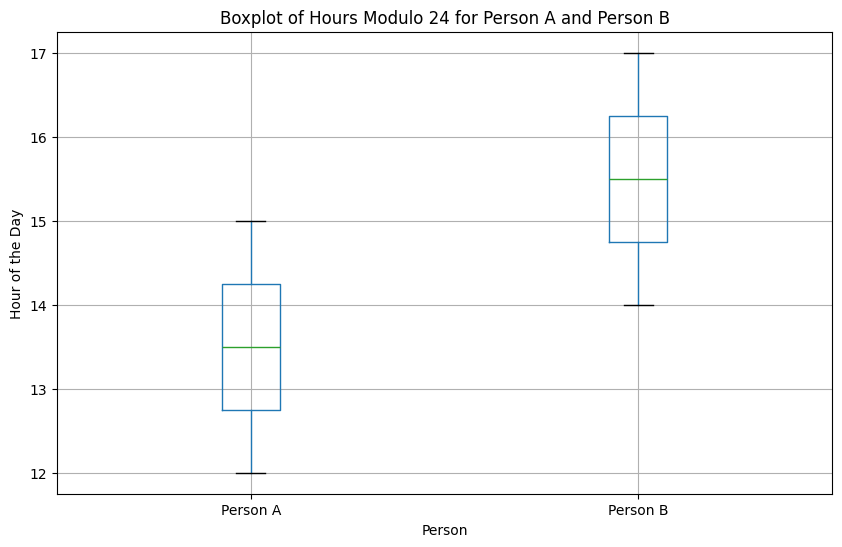

In [91]:
# from df (full) remove only those without time of shout.

# Given times for Person A
times_a = ['14:30', '12:45', '15:05', '13:56']

# Convert times to datetime objects for Person A
time_objects_a = [pd.to_datetime(time, format='%H:%M') for time in times_a]

# Extract hour component modulo 24 for Person A
hours_mod_24_a = [time.hour % 24 for time in time_objects_a]

# Given times for Person B (one hour later)
times_b = ['15:30', '13:45', '16:05', '14:56']

# Convert times to datetime objects for Person B
time_objects_b = [pd.to_datetime(time, format='%H:%M') for time in times_b]

# Extract hour component modulo 24 for Person B
hours_mod_24_b = [(time.hour + 1) % 24 for time in time_objects_b]  # Adding 1 hour for Person B

# Create DataFrame for both persons
df = pd.DataFrame({'Person A': hours_mod_24_a, 'Person B': hours_mod_24_b})

# Plot boxplot for both persons
fig, ax = plt.subplots(figsize=(10, 6))
df.boxplot(ax=ax)

# Set labels and title
ax.set_xlabel('Person')
ax.set_ylabel('Hour of the Day')
ax.set_title('Boxplot of Hours Modulo 24 for Person A and Person B')

# Show plot
plt.show()




## length of time and top 10 incidents? 



# Crew analysis



## Coxwains and who would be best to train next - experience




# Pager 



## (number of incidents in a date range) (spring/summer/autum/winter(barplot)


# shout tags


## shout tags - dates?

## shout tags and time taken.




